In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.signal
import os, sys
import math
import numpy as np
import time
import fluidfoam

# Pure solution loading
Loads an OpenFOAM case by time directories in a given interval.
Mind the case must be reconstructed.

In [52]:
from tqdm import tqdm
from fluidfoam import readscalar, readvector,readmesh
sol='/media/data5tbNote/OpenFOAM/plane'
# print(sol)
what='U'

frm=24000
to=24000

#===================================================================
def readVal(sol,fields,readMesh=True,time='latestTime',rtype='vector',verbose=True):
    # reads vector value on intrinsic grid
    if time is None: time='latestTime'
    #[X,Y,Z],[UMean2]=OFpy.readVal(sol,['UMean'],readMesh=True,time=None)
    outlist=[]
    if rtype=='vector':
        for name in fields:
            outlist.append(readvector(sol,time_name=time,name=name,verbose=verbose))
    else:
        for name in fields:
            outlist.append(readscalar(sol,time_name=time,name=name,verbose=verbose))
    if readMesh:
        X,Y,Z=readmesh(sol,verbose=verbose)
        return [X,Y,Z],outlist
    else:
        return outlist

# Nearest time directory to a given value
def nearest(t, timelist,verbose=True):
    if t<timelist[0]:
        if verbose: print('Nearest warning: time less than minimal time read')
        return 0
    elif t>timelist[-1]:
        if verbose: print('Nearest warning: time greater than maximal time read')
        return timelist.shape[0]-1
    else:
        for i in range(0,timelist.shape[0]-1):
            if timelist[i]<=t<timelist[i+1]:
                return i
        # return -1
def scientific(num):
    if 1e-2<=num<1000:
        return "{:.2f}".format(num)
    else:
        mant,power="{:.2e}".format(num).split('e')
    return mant+r'\times 10^{'+str(int(power))+'}'
timedirs=[]
for Dir in os.listdir(sol):
    try:
        float(Dir)
        timedirs.append(Dir)
    except:
        pass
timedirs.sort()
timedirs=timedirs[1:]
tmp=[]
for timedir in timedirs:
    if frm<=float(timedir)<=to:
        tmp.append(timedir)
timedirs=tmp
del(tmp)


verbose=False
Ud=[]
if len(timedirs)==0:
    print('No directories found. Reconstruction is plausibly required')

else:
    rtype='vector' if what in ['U','UMean','UPrime2']  else 'scalar'
    for timedir in tqdm(timedirs):
        if timedir==timedirs[0]:
            [X,Y,Z],[U]=readVal(sol,[what],rtype=rtype,readMesh=True,time=timedir,verbose=verbose);
        else:
            [U]=readVal(sol,[what],rtype=rtype,readMesh=False,time=timedir,verbose=verbose);
        Ud.append(U)

    Ud=np.array(Ud)
    timedirs=np.array([float(timedir) for timedir in timedirs])
    print('Contains: {} temporal points'.format(str(len(timedirs))))
    print('Time from {} to {} s'.format(str(round(timedirs[0],4)),str(round(timedirs[-1],4))))

100%|█████████████████████████████████████████████| 1/1 [01:19<00:00, 79.94s/it]

Contains: 1 temporal points
Time from 24000.0 to 24000.0 s


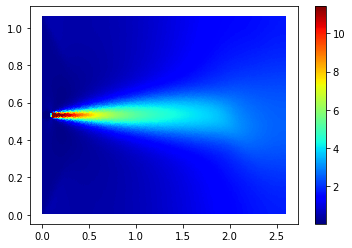

In [18]:
plt.tripcolor(X,Z,Ud[0][0],cmap='jet'); plt.colorbar()

## Interpolation
Submerge a computational domain into a cuboid and interpolates data on a uniform 3D grid.

In [28]:
from scipy.interpolate import griddata

# Number of division for interpolation
ngridx = 300
ngridy = 1
ngridz = 1
#===================================================================
# Interpolation grid dimensions
xinterpmin = np.min(X)
xinterpmax = np.max(X)
yinterpmin = np.min(Y)
yinterpmax = np.max(Y)
zinterpmin = np.min(Z)
zinterpmax = np.max(Z)

t00=time.time()
# Interpolation grid
xi = np.linspace(xinterpmin, xinterpmax, ngridx)
yi = np.linspace(yinterpmin, yinterpmax, ngridy)
zi = np.linspace(zinterpmin, zinterpmax, ngridz)

xinterp, yinterp, zinterp = np.meshgrid(xi, yi, zi ,indexing='ij')
# Structured grid creation
# xinterp, yinterp = np.meshgrid(xi, yi)

# Interpolation of scalra fields and vector field components
# alpha_i = griddata((x, y), alpha, (xinterp, yinterp), method='linear')
Uxi = np.array([ griddata((X, Y, Z), Uxslice, (xinterp, yinterp, zinterp), method='nearest').transpose(2,1,0) for Uxslice in Ud[:,0,...] ]) # TxZxYxX
Uyi = np.array([ griddata((X, Y, Z), Uyslice, (xinterp, yinterp, zinterp), method='nearest').transpose(2,1,0) for Uyslice in Ud[:,1,...] ]) # TxZxYxX
Uzi = np.array([ griddata((X, Y, Z), Uzslice, (xinterp, yinterp, zinterp), method='nearest').transpose(2,1,0) for Uzslice in Ud[:,2,...] ]) # TxZxYxX
# vely_i = griddata((X, Y), Ud[-1][1, :], (xinterp, yinterp), method='linear')

print("Elapsed time: "+str(round(time.time()-t00))+f' s for {Uxi.shape[0]} timedirs')

Elapsed time: 0 s for 1 timedirs


In [25]:
Uxi.shape

(1, 1, 1, 300)

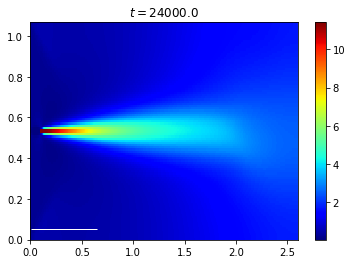

In [23]:
ti=0
plt.pcolormesh(xi,zi,Uxi[ti][:,0,:],cmap='jet',shading='auto'); plt.title(f'$t={timedirs[ti]}$')
d=0.5
plt.gca().add_patch(plt.Polygon([[xi[0],yi[0]],[xi[0],yi[-1]],[xi[0]+(xi[-1]-xi[0])*0.5*(1-d),yi[0]]],color='white'))
c=0.5*np.max(Uyi)
# plt.clim(-c,c)
plt.colorbar()

# Postprocessing loading
Loading of a structured grid matrix written via 'Probes' intrinsic OpenFOAM function. To read correctly spatial shape is required.

### Probes, to write
Make sure the controlDict has the necessary block with probes template.
The cell below writes only history points coordinates.

In [38]:

controlDict='/media/data5tbNote/OpenFOAM/salinityBuoyancy/system/controlDict'

Nx=150
Ny=100
Nz=1

c=0.448

probes_z=np.linspace(0.01,0.01,Nz)
probes_y=np.linspace(-15*c,15*c,Ny)
probes_x=np.linspace(-15*c,20*c,Nx)

if 1: # if write
    with open(controlDict,'r') as f:
        text=f.read()


    splittext=text.split('probeLocations')
    head=splittext[0]
    # print(splittext[0])
    tail=splittext[1].split(');',maxsplit=1)[1]

    hptslist=f'\n// Nx={Nx}; Ny={Ny}; Nz={Nz}\n'
    for iz in range(0,Nz):
        for iy in range(0,Ny):
            for ix in range(0,Nx):
                hptslist+='({:.6e}   {:.6e}    {:.6e})\n'.format(probes_x[ix],probes_y[iy],probes_z[iz])


    output=head+'probeLocations\n(\n'+hptslist+');'+tail
    with open(controlDict,'w+') as f:
        f.write(output)
    print('WRITTEN IN:',controlDict)


WRITTEN IN: /media/data5tbNote/OpenFOAM/salinityBuoyancy/system/controlDict


### Vector loading

In [54]:
# PROBES
casePath =  '/media/data5tbNote/OpenFOAM/plane'


ui=fluidfoam.readpostpro.readprobes(path=casePath, 
                        probes_name='probes', time_name='latestTime', name='U') # time_name is start writing (0)
ld={}
pts=ui[0]
times=ui[1]
# U11000 [0] -- hpts matrix {(x,y,z)}
# U11000 [1] -- times array
# U11000 [2] -- (T x points x component) probes data
ui=ui[2] [:][:,0] # 2, time index, :, component



Reading file /media/data5tbNote/OpenFOAM/plane/postProcessing/probes/12000/U
29 probes over 6 timesteps


## PSD

In [43]:
spArr=[]
dt=times[1]-times[0]
T=times[-1]-times[0]
for ix in range(0,uxmatrix.shape[-1]):
    sp=(abs(np.fft.rfft(uxmatrix[:,0,0,ix]))**2+
       abs(np.fft.rfft(uymatrix[:,0,0,ix]))**2+
       abs(np.fft.rfft(uzmatrix[:,0,0,ix]))**2       
       )*dt**2/T
    spArr.append(sp)
freq=np.fft.rfftfreq(times.shape[0],d=dt)
spArr=np.array(spArr)

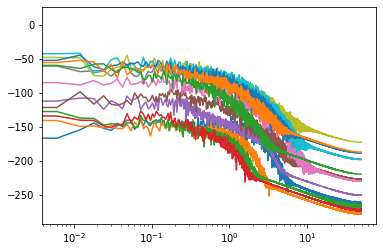

In [39]:
for i in range(0,spArr.shape[0]):
    plt.plot(freq*0.0245/2063,20*np.log10(spArr[i]/2063))
plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('$St$',fontsize=15)
# plt.ylabel('PSD, db')

### Scalar loading

In [90]:

Nz=1; Ny=1; Nx=27 # make sure probes are written on a flattened meshgrid
#===================================================================
t00=time.time()
data=np.loadtxt(file)
times=fluidfoam.readpostpro.readprobes(path=casePath, 
                        probes_name='probes', time_name='latestTime', name='T') # time_name is start writing (0)
pts=U11000[0]
times=U11000[1] 
temp=temp[2].reshape(-1,Nz,Ny,Nx)

# POD
Decompose a given time-space solution in a form:

$$u(x,y,t)\approx\sum_{i=1}^n \Phi_i(x,y)T_i(t)$$

Number of modes $n$ is selected by $n_components$ parameter. Also there is an option to select $n$ automatically to fit a given share of energy $p$ ($0<p<1$). To use set $n_components$ with a $p$ prefered.

One may select between alorythm of decomposition. Set $algo = "svd"$ for exact decomposition via singular values (mind you may face a memory overflow for big meshes) or $algo="sklearnPCA"$ for faster algorythm that may sometimes decommpose not very accurately.

### POD computing

In [1]:
from sklearn.decomposition import PCA

what=Uxi[:,0,...]
xx,yy=np.meshgrid(xi,yi)
algo='sklearnPCA' # sklearnPCA / svd

tbi=0#nearest(1,timedirs)
tei=timedirs.shape[0]#nearest(1.2,timedirs)#int(5/il_dt_hpts)

ifsave=0

n_components=5 # if integer, geiven number of modes will be considered;   if <1, number of modes
#                           will be automaticaaly calculated to reach a given cumulative energy value

bb=1 # set 3 for rough test run and 1 for clean output 
#===================================================================
t00=time.time()



if (tbi>timedirs.shape[0]):
    print('t0>T_max!!!  Set at 0.')
    tbi=0
if (tei>timedirs.shape[0]): 
    print('t>T_max!')
    tei=timedirs.shape[0]

mToPod=what[tbi:tei,::bb,::bb].reshape(-tbi+tei,-1)
xxToPod=xx[::bb,::bb];yyToPod=yy[::bb,::bb]                                                                                      
print("POD for spatial resolution:",xx.shape)

 # <--------------------------------
if algo=='sklearnPCA':
    method = PCA(n_components=n_components) 
    modes=method.fit_transform(mToPod.T).T
    w=method.explained_variance_s
    yP=method.components_.T
    
    for i in range(0,modes.shape[0]):
        coef_i=np.linalg.norm(modes[i])
        modes[i]/=coef_i
        yP[:,i]*=coef_i
    n_components=modes.shape[0]
if algo=='svd':
    _,w,modes=np.linalg.svd(mToPod) 
    w=(w[:n_components])**2
    yP=mToPod@modes.T
    modes=modes[:n_components]
    yP=yP[:,:n_components]
# modes*=-1;yP*=-1

print("POD of mode \"{}\" done in {} s".format(algo,str(round(time.time()-t00))))


NameError: name 'Uxi' is not defined

### POD plotting

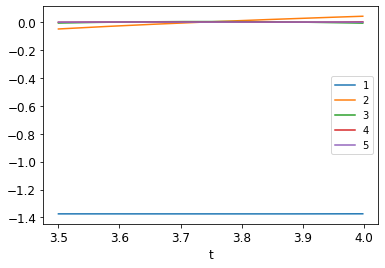

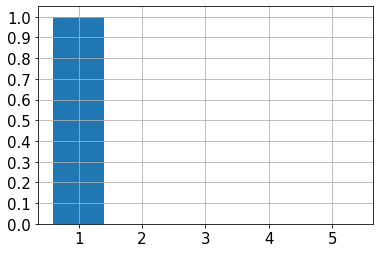

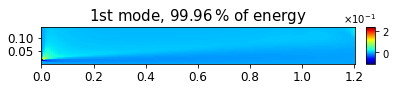

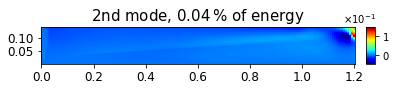

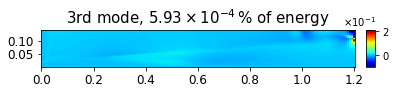

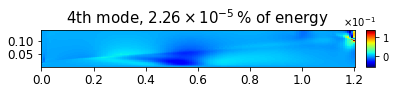

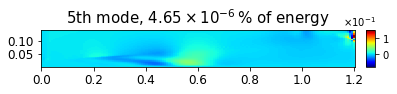

In [124]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
podPath='.' # where to save
plu='' # save name affix to avoid interference 

ncs=n_components
ticksize=12
for ti in range(0,n_components):
    plt.plot(timedirs[tbi:tei],yP[:,ti],label=ti+1)
plt.legend();plt.xlabel('t',fontsize=ticksize);    plt.tick_params(labelsize=ticksize)
# mpl.rcParams['figure.dpi'] = 300
plt.figure()
plt.bar(np.arange(ncs)+1,(w[:ncs]/max(w)))
plt.xticks(np.arange(ncs)+1);
plt.yticks(np.arange(11)/10);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

if ifsave:
    #print('directory:'+podPath)
    plt.savefig(podPath+'/eigenvalues'+plu+'.png',dpi=300,bbox_inches='tight')
    plt.show()

for ti in range (0,n_components):
    plt.figure()
    plt.pcolormesh(xxToPod,yyToPod,(modes[ti].reshape(xxToPod.shape)),cmap='jet',shading='auto')#,cmap='jet')
    ax=plt.gca()
    ax.set_aspect('equal')
    if ti==0:
        appendix='st'
    elif ti==1:
        appendix='nd'
    elif ti==2:
        appendix='rd'
    else:
        appendix='th'
    plt.title(str(ti+1)+appendix+r' mode, ${}\,\%$ of energy'.format(scientific(100*w[ti]/np.sum(w))),fontsize=15)
    plt.tick_params(labelsize=ticksize)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%",pad=0.15)
    #cbar=plt.colorbar(cax=cax)
    #cbar.ax.tick_params(labelsize=10)
    #cbar.formatter.set_powerlimits((0, 0))
    cbformat = ticker.ScalarFormatter()
    cbformat.set_scientific('%.2e')
    cbformat.set_powerlimits((-0,0))
    cbformat.set_useMathText(True)
    cbar = plt.colorbar(cax=cax, location='right', format=cbformat)
    if ifsave:
        plt.savefig(podPath+'/eigenmode{}'.format(ti)+plu+'.png',dpi=300,bbox_inches='tight')
    plt.show()

# POD for both components

In [137]:
from sklearn.decomposition import PCA

xx,yy=np.meshgrid(xi,yi)
algo='svd' # sklearnPCA / svd

tbi=0#nearest(1,timedirs)
tei=timedirs.shape[0]#nearest(1.2,timedirs)#int(5/il_dt_hpts)

n_components=5 # <--------------------------------

ifsave=False
# ifsave=True

bb=1 # set 3 for rough test run and 1 for clean output 
#===================================================================
t00=time.time()



if (tbi>timedirs.shape[0]):
    print('t0>T_max!!!  Set at 0.')
    tbi=0
if (tei>timedirs.shape[0]): 
    print('t>T_max!')
    tei=timedirs.shape[0]

mToPod=np.concatenate((Uyi[tbi:tei,0,::bb,::bb].reshape(-tbi+tei,-1),Uxi[tbi:tei,0,::bb,::bb].reshape(-tbi+tei,-1)),axis=1)
xxToPod=xx[::bb,::bb];yyToPod=yy[::bb,::bb]                                                                                      
print("POD for spatial resolution:",xx.shape)


if algo=='sklearnPCA':
    method = PCA(n_components=n_components) 
    modes=method.fit_transform(mToPod.T).T
    w=method.explained_variance_#w=(m.diagonal()) # abs of eigenvalues
    yP=method.components_.T
    
    for i in range(0,modes.shape[0]):
        coef_i=np.linalg.norm(modes[i])
        modes[i]/=coef_i
        yP[:,i]*=coef_i
    n_components=n_components=modes.shape[0]
if algo=='svd':
    _,w,modes=np.linalg.svd(mToPod) # <----------------------------------
    w=(w[:n_components])**2
    yP=mToPod@modes.T
    modes=modes[:n_components]*(-1)
    yP=yP[:,:n_components]*(-1)
# modes*=-1;yP*=-1

print("POD of mode \"{}\" done in {} s".format(algo,str(round(time.time()-t00))))


POD for spatial resolution: (100, 150)
POD of mode "svd" done in 179 s


### POD plotting

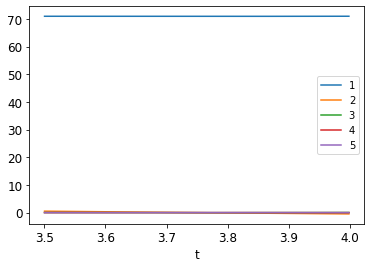

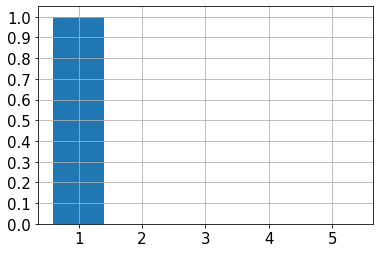

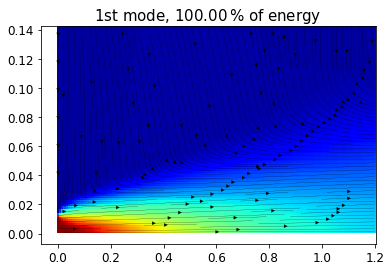

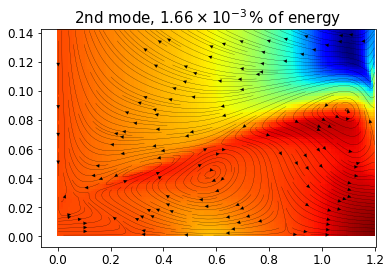

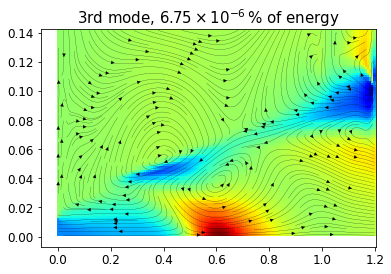

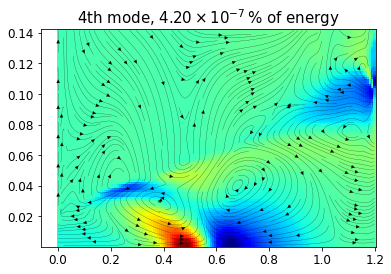

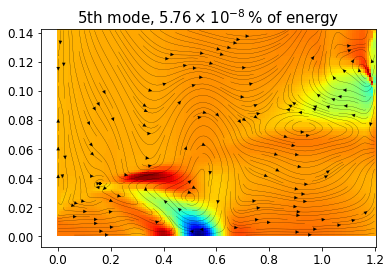

In [138]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

podPath='.' # where to save
plu='2' # save name affix to avoid interference 

density=2 # for streamlines
ncs=n_components
ticksize=12
for ti in range(0,n_components):
    plt.plot(timedirs[tbi:tei],yP[:,ti],label=ti+1)
plt.legend();plt.xlabel('t',fontsize=ticksize);    plt.tick_params(labelsize=ticksize)
# mpl.rcParams['figure.dpi'] = 300
plt.figure()
plt.bar(np.arange(ncs)+1,(w[:ncs]/max(w)))
plt.xticks(np.arange(ncs)+1);
plt.yticks(np.arange(11)/10);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

if ifsave:
    #print('directory:'+podPath)
    plt.savefig(podPath+'/eigenvalues'+plu+'.png',dpi=300,bbox_inches='tight')
    plt.show()

for ti in range (0,n_components):
    plt.figure()
    vym=modes[ti][:int(modes.shape[1]/2)].reshape(xxToPod.shape)
    vxm=modes[ti][int(modes.shape[1]/2):].reshape(xxToPod.shape)
    ax=plt.gca()
    plt.pcolormesh(xxToPod,yyToPod,vxm,cmap='jet')
    plt.streamplot(xxToPod,yyToPod,vxm,vym,density=density,linewidth=0.2, arrowsize=0.8,color='k')
    ax=plt.gca()
    #ax.set_aspect('equal')
    if ti==0:   appendix='st'
    elif ti==1: appendix='nd'
    elif ti==2: appendix='rd'
    else:       appendix='th'
    plt.title(str(ti+1)+appendix+r' mode, ${}\,\%$ of energy'.format(scientific(100*w[ti]/np.sum(w))),fontsize=15)
    plt.tick_params(labelsize=ticksize)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="3%",pad=0.15)
    #cbar=plt.colorbar(cax=cax)
    #cbar.ax.tick_params(labelsize=10)
    #cbar.formatter.set_powerlimits((0, 0))
    # cbformat = ticker.ScalarFormatter()
    # cbformat.set_scientific('%.2e')
    # cbformat.set_powerlimits((-0,0))
    # cbformat.set_useMathText(True)
    # cbar = plt.colorbar(cax=cax, location='right', format=cbformat)
    if ifsave:
        plt.savefig(podPath+'/eigenmode{}'.format(ti)+plu+'.png',dpi=300,bbox_inches='tight')
    plt.show()

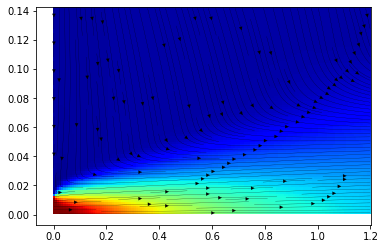

In [139]:
plt.pcolormesh(xi,yi,Uxi[-1,0],cmap='jet')
plt.streamplot(xi,yi,Uxi[-1,0],Uyi[-1,0],density=density,linewidth=0.2, arrowsize=0.8,color='k')

### Reconstructed solution for the number of modes given

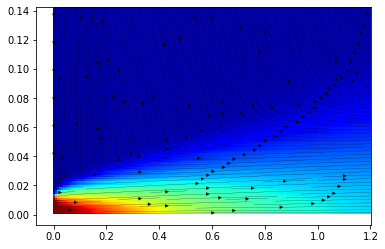

In [141]:
restructed=(yP @ modes).reshape([-1,2]+list(xxToPod.shape))
plt.pcolormesh(xxToPod,yyToPod,restructed[-1,1],cmap='jet')
plt.streamplot(xxToPod,yyToPod,restructed[-1,1],restructed[-1,0],density=density,linewidth=0.2, arrowsize=0.8,color='k')